<table>
    <tr>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095321-45e05a00-165e-11eb-9c60-b90723caba4a.png"                  width="150">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095369-b8513a00-165e-11eb-9ef2-e2fcef626f88.jpeg"                width="150">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095285-c0f54080-165d-11eb-82bf-e0c032a1e333.png"                width="80">
        </td>
        <td><img src="https://user-images.githubusercontent.com/73366653/97095257-825f8600-165d-11eb-8704-c998a9fae1ce.png"                width="80">
        </td>
    </tr>
</table>

This file shows the results of simulations done in [V1G_MPC.ipynb](V1G_MPC.ipynb) and which results are saved in [MPC_V1G](../DataFiles/MPC_V1G/).

Run the cells as they are up to section [EVs Data](#EVDATA). There,  one can choose either to load the file associated with 1 Ev, 14 Evs or 55 EVs. 

In the following section [Initiate parameters](INITPARAMS) one can change the parameters `hor_string` (see [probVar](../Modules/probVar.py) for a complete list of all the value of the MPC's Horizon ) and `α` (`α` $\in $ { 0. , 0.5, 0.999 })

The [last section](#ENMIS) shows the energy mismatch for a chosen value of `α` for all value of the MPC's Horizon.

# Import modules

In [1]:
# testing 

#Optimization Modelling Lanuage#
import cvxpy as cp

# allow to load save python file
import pickle

#Solvers#
import mosek

#Additional packages
import pandas as pd, numpy as np,  matplotlib.pyplot as plt
import random
from array import *
from statistics import mean
from itertools import chain
from scipy import signal, spatial
from scipy.stats import norm
import math 

import importlib # To relaod module


#Profiling 
import time
from tqdm import tqdm

# pd.options.mode.chained_assignment = None  # default='warn'

import sys
# %jupyter matplotlib
%matplotlib inline


# Add modules path to the system if not present
module_path = '../Modules/'
if module_path not in  sys.path: sys.path.append(module_path)


# My modules 
import probVar, probVar_update, brp, mpc, regSwitchSolarPred as rssp
# importlib.reload(probVar_update)

## Data Input

In [2]:
# import following variable in the working environement 
from probVar import z_base_prim, z_base_sec, s_base, fullDay_min, err_load, err_ev, eff_chrg
from probVar import e_bat, soc_min, day2_min, p_max, hor_dict, soc_min, soc_max, soc_min_dep
from probVar import soc_max_arr, voltage_tolerance, nom_voltage, v_base_sec, sld_freq

mean_freq = 15 # Define the sampling frequency
probVar_update.Δt(mean_freq) # Update the sampling frequency

## Import pecan street data

In [3]:
folder_name = "../DataFiles/PecanStreet/"
file_name = folder_name + "1minute_data_newyork_dataid27.csv"

#reading file 
data_csv = pd.read_csv(file_name,index_col=False, keep_default_na=False,nrows=5000000)

## Shape Simulation days data

In [4]:
nb_day2_load = 5
year_month = '2019-07-'
day1 = 1;

start_day = year_month+str(day1)

end_day  = year_month+str(day1+nb_day2_load)

# Get the customers id
custs_id = data_csv.dataid.drop_duplicates(keep='first').values

#### ----------------------------    Reshape and extract load demand      -------------------------------------------------

data_custid_load_dict = {} # dictionary of load demand
data_custid_pv_dict = {} # dictionary of load demand


for cur_cust_id in custs_id: # for each customer in the pecan street extracted data 
    
    cust_p_pv = 0   # variable to store the customer  P_pv
    cust_p_ev = 0   # variable to store the customer  P_ev
    
    data_custid = data_csv[data_csv.dataid==cur_cust_id] # Extract only the data of the customer identified by cur_cust_id

    # For the identified customer extract the data delimited by start_day and end_day
    data_custid_day = data_custid[(start_day <= data_custid.localminute) & (data_custid.localminute < end_day)]

    #TODO: data_custid_day.localminute.replace('00-05','') 
    #     Work on replacing '00-05' by '' later on 
    
    data_custid_day = data_custid_day.sort_values(by='localminute'); # order data by minutes in ascending order 
    data_custid_day.index = pd.date_range(start_day ,freq='T',periods=len(data_custid_day)) # use panda date_range to index 
    
    tot_min = len(data_custid_day)# Tatal minutes

    # Get rid of useless collum 
    data_custid_day.drop(labels=['dataid','localminute','leg1v','leg2v'], axis=1,inplace=True)

    # extract PV_data 
    cust_p_pv =  data_custid_day[['solar','solar2']].sum(axis=1)
    if cust_p_pv.dtype == 'float64':      # If the current client has PPv installed
        cust_p_pv = cust_p_pv.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    
    
    #Extract EV_data
    cust_p_ev =  data_custid_day[['car1','car2']].sum(axis=1)
    if cust_p_ev.dtype == 'float64':      # If the current client has EV 
        cust_p_ev = cust_p_ev.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    

    # Current client load total load 
    cust_p_load = data_custid_day.grid
    cust_p_load = cust_p_load.resample(probVar.ds_freq_str, label = 'right').mean() # Downsampling and mean
    
    
    # Since the load included pv and ev , they need to be extracted in order to get only the house demand
    # Extract P_pv
    if cust_p_pv.dtype == 'float64':      # If the current client has PPv installed
        cust_p_pv[cust_p_pv <0 ] = 0      # Set to 0 when p_pv < 0 (due to measurement noise during night) 
                                          # (P_pv > 0  ==> production )
        # Add p_pv of the current custm in the associated dict
        data_custid_pv_dict.update({cur_cust_id : cust_p_pv})            
        
        cust_p_load = cust_p_load + cust_p_pv
      
    # Remove  P_ev
    if cust_p_ev.dtype == 'float64':      # If the current client has EV 
        cust_p_load = cust_p_load - cust_p_ev
        
    # add the extracted load and Pv of the current customer in the dictionary
    data_custid_load_dict.update({cur_cust_id : cust_p_load})

    
    
first_ind = list(data_custid_pv_dict.keys())[0] # Get index of the first elm in the dict
first_shape = data_custid_pv_dict[first_ind].shape[0] # Get len of the first elm in the dict

# get index of all element in the dict which length differs from the first one
ind_list = [elm  for elm in data_custid_pv_dict.keys() if data_custid_pv_dict[elm].shape[0] != first_shape]

### Inputing Data Files for the IEEE LVTF Network

In [5]:
folder_name = "../DataFiles/European_LV_CSV_simplified_new/"

lines_codes_df = pd.read_csv(folder_name + "LineCodes.csv", index_col=False, skiprows=1)
lines_df = pd.read_csv(folder_name + "Lines_reduced.csv", index_col=False, skiprows=1)
bus_df = pd.read_csv(folder_name + "Buscoords_reduced.csv", index_col=False, skiprows=1)

#Load data For the customer in the IEEE network 
load_data_df = pd.read_csv(folder_name + "Loads_reduced.csv", index_col=False, skiprows=2)

### Import the solar data from the regime switching Model
The parameters are extracted using the simulation done in [SolarPre_DataExtraction](SolarPre_DataExtraction.ipynb). You may see the above mention file for more details.

In [6]:
# read saved parameters files 
fi_name = 'regSwitching_params.pkl'
main_folder = '../DataFiles/'
saving_folder_file = main_folder + fi_name


extracted_date = '2020 06 24' # Starting date 
reg_switching_pv = rssp.definePpv_PlanReal(nb_day2_load, extracted_date , 2, 
                                           saving_folder_file, scale=150).resample(probVar.ds_freq_str, label = 'right').mean()

### Associate with each user in the IEEE network a Pv


In [7]:
# Create dictionaries to store PV data 
p_pv = {} # Active pv  for each customer in the network 
#q_pv = {} # Reactive pv  for each customer in the network 
p_pv_pred = {}

pv_dn_keys = list(data_custid_pv_dict.keys()) # Get index of elm in the dict
len_pv = len(data_custid_pv_dict) # Get number of elm p_pv dict

# For all elm in the load_data_df dataframe
for i in load_data_df.index:
    bus_nbr = load_data_df.loc[i]['Bus'] #Get bus number at row i in the dataframe
    val = reg_switching_pv.real_GHI.values*1000/s_base
    # temporary 
    val[96*2:96*3] = val[96*3:96*4]
    val[96*3:96*4] = val[96*3:96*4]/2
    val[252:264] = val[252:264]*2
 
    p_pv.update({ bus_nbr : val })                 # using real data from model switching 
    p_pv_pred.update({ bus_nbr : reg_switching_pv.engagement_GHI.values*1000/s_base }) # The PRP P_pv is based on on the  using prediction

### Associate with each user in the IEEE network a $Pv_{plan}$

In [8]:
# Create P_pv plan based on the associated function 
# plan_type = 0 ==>> Using the error based Prevision of P_pv
# plan_type = 1 ==>> Using the persistance based Prevision of P_pv 
p_pv_plan = brp.def_ppv_plan(load_data_df, p_pv_pred, plan_type=0, err_pv_f=0.,avr_freq=15)

# Note We are using the p_pv_pred in <<brp.def_ppv_plan(args)>> since we are supposing that P_pv_plan 
# is based on some predicted dayType that is not biased by the error term. One may easily change 
# `p_pv_pred` by the actual P_pv `p_pv` and add an error term if the engagement is based on a biased real P_pv.

### Plot the actual and the planned $P_{pv}$


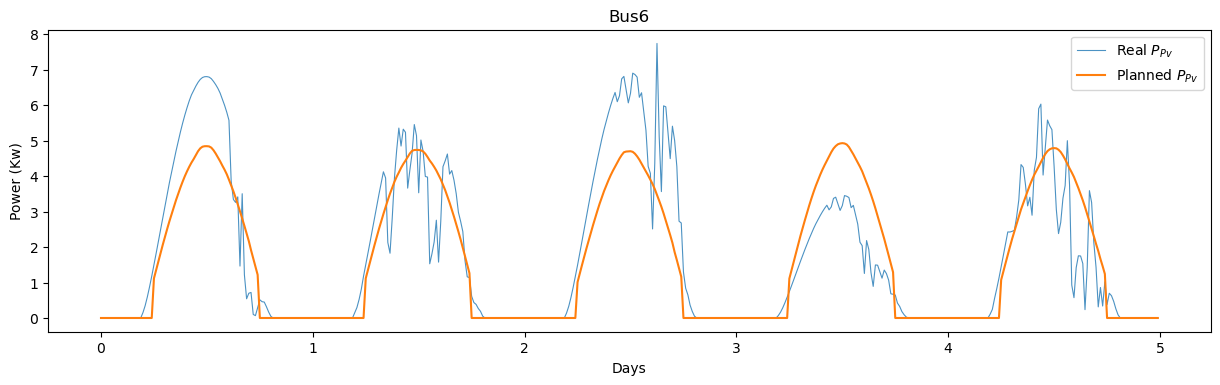

In [9]:
cur_bus = 6
fig, axx = plt.subplots(1,figsize=(15,4),dpi=100,sharex=True);
axx.plot(p_pv[cur_bus]*s_base/1000, label='Real $P_{Pv}$', lw=0.8, alpha=0.8,);
axx.plot(p_pv_plan[cur_bus]*s_base/1000,label='Planned $P_{Pv}$')
axx.set(title='Bus '+str(cur_bus), ylabel='Power(kw)')
axx.legend()
# plt.xticks(range(0,(tot_min+probVar.Δt)//probVar.Δt, fullDay_min//probVar.Δt), labels=range(0,6),);
plt.xticks(range(0,(len(p_pv_plan[cur_bus])*mean_freq+probVar.Δt)//probVar.Δt, fullDay_min//probVar.Δt), labels=range(0,nb_day2_load+1) );

axx.set(xlabel='Days', ylabel='Power (Kw)', title = 'Bus'+str(cur_bus));
# plt.xlim((96,192))


## Load Profiles Input and Generating Forecasted Load Data

In [10]:
# Reading Load Profiles
p_load = {}

# update cust_id using the load dict elm 
custs_id = list(data_custid_load_dict.keys())

p_load_plan = {} 

sizz = len(custs_id)

# We are using Pecan street user data in the IEEE network. Since there is more users in the IEEE network 
# than in the PecanStreet dataset, we duplicate some of them
for i in range(len(load_data_df)):
    p_load.update({load_data_df.loc[i]['Bus']: data_custid_load_dict[custs_id[i%sizz]].values*1000/s_base})
    
    
# Generating Planned Load data 
p_load_plan = {}
avr_freq = 15 # Averaging frequency in minutes. Make sure the averaging frequency is >= probVar.Δt

for elm in p_load:
    
    lst = p_load[elm]
    load_values = np.zeros((len(lst)));
    
    n = avr_freq//probVar.Δt # 15 minutes avg. 
                       
    for j in range(0,len(lst),n): 
        load_values[j:j+n] = np.mean(lst[j:j+n])

    # Planned Load 
    p_load_plan.update({elm: load_values})

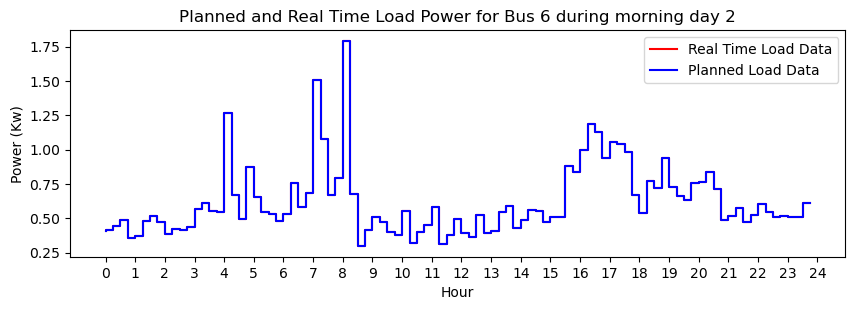

In [11]:
#Plotting Planned and Realtime Load data for bus 2
plt.figure(figsize=(10,3), dpi= 100, facecolor='w', edgecolor='k')
lim_plot0 = day2_min//probVar.Δt
lim_plot1 = (probVar.fullDay_min + int(day2_min) )//probVar.Δt
plt.step(p_load[6][lim_plot0:lim_plot1]*s_base/1000, 'r-',)
plt.step(p_load_plan[6][lim_plot0:lim_plot1]*s_base/1000, 'b-')

plt.legend(['Real Time Load Data', 'Planned Load Data'], loc='best')
plt.title('Planned and Real Time Load Power for Bus 6 during morning day 2')
# plt.xticks(range(0,lim_plot1,int(60/ΔT)),)
plt.xticks(range(0, int((fullDay_min + probVar.Δt)//probVar.Δt),60//probVar.Δt), range(0,25));
plt.xlabel('Hour')
plt.ylabel('Power (Kw)');
# 

<a id="EVDATA"></a>

## EVs Data

In [12]:
# Read Ev_DATA dataframe and update its location in the probVar file so that all the other module access
# the file loaded in the main i.e. here 

# probVar_update.read_EV_df("../DataFiles/EVsData/EVs_Data_5_1.csv")  # file 1 EV
probVar_update.read_EV_df("../DataFiles/EVsData/EVs_Data_6.csv")  # file 14 EVs
# probVar_update.read_EV_df("../DataFiles/EVsData/EVs_Data_5.csv")  # File 55 EVs 

# load file that consists  of the  EV_number and associated bus number 
evs_data_df = probVar.evs_data_df

Ev_data_dataframe updated with the NEW file located at ../DataFiles/EVsData/EVs_Data_6.csv


<a id="INITPARAMS"></a>

## Initiate parameters

Load the result of the simulation for the parameters given by $\alpha$ and the numbers of Ev in the network

In [13]:
nb_sim_days = 3# Total number of simulation days
t_sim = nb_sim_days*probVar.fullDay_min//probVar.Δt      #Total duration of the study(in minutes)

hor_string = '15mn'            # See probVar.hor_dict for all the value of the Horizon
α = 0.                         # 0. | 0.5 | 0.999

file_toRead_loc = '../DataFiles/MPC_V1G/' # Define File location
# Define file name
file_name = 'MPC_Mosek_RelaxVar='+str(α)+'_'+ str(len(evs_data_df))+'cars3Days_Pv_rgSwitch_hor='+hor_string+'.pkl'
file_to_read = open(file_toRead_loc+file_name, 'rb')

result_dict2 = pickle.load(file_to_read);

zero_to_k_Emis = result_dict2['E_mis_min']
p_ev_chrg_prob = result_dict2['p_ev_chrg_prob']
soc_prob = result_dict2['soc_prob']
theta_prob = result_dict2['theta_prob']
ev_data = result_dict2['Ev_data']
p_ev_plan = result_dict2['pev_plan']

### Show Ev arrival and departure hour

In [14]:
nb_ev_to_show = 3
nb_arr_dep = ev_data[list(ev_data.keys())[0]]['nb_arr_dep']
for elm in range(1,nb_arr_dep+1):
    brp.printArrDep_time(ev_data,'t_arr'+str(elm), 't_dep'+str(elm),nb_ev_to_show)
    print()

  	 	      t_arr1,     t_dep1
   	 	    ----------------------
Ev on bus: 78 :  ['0D: 0h0', '0D: 6h45']
Ev on bus: 100 :  ['0D: 0h0', '0D: 6h0']
Ev on bus: 112 :  ['0D: 0h0', '0D: 6h30']

  	 	      t_arr2,     t_dep2
   	 	    ----------------------
Ev on bus: 78 :  ['0D: 9h45', '0D: 11h0']
Ev on bus: 100 :  ['0D: 10h45', '0D: 13h0']
Ev on bus: 112 :  ['0D: 10h0', '0D: 13h0']

  	 	      t_arr3,     t_dep3
   	 	    ----------------------
Ev on bus: 78 :  ['0D: 18h45', '1D: 6h0']
Ev on bus: 100 :  ['0D: 18h30', '1D: 6h0']
Ev on bus: 112 :  ['0D: 19h30', '1D: 8h0']

  	 	      t_arr4,     t_dep4
   	 	    ----------------------
Ev on bus: 78 :  ['1D: 9h45', '1D: 12h0']
Ev on bus: 100 :  ['1D: 10h30', '1D: 13h0']
Ev on bus: 112 :  ['1D: 10h45', '1D: 13h0']

  	 	      t_arr5,     t_dep5
   	 	    ----------------------
Ev on bus: 78 :  ['1D: 17h0', '2D: 8h0']
Ev on bus: 100 :  ['1D: 20h0', '2D: 8h0']
Ev on bus: 112 :  ['1D: 20h0', '2D: 6h0']

  	 	      t_arr6,     t_dep6
   	 	    ----

### Plot Ev consumption for one bus

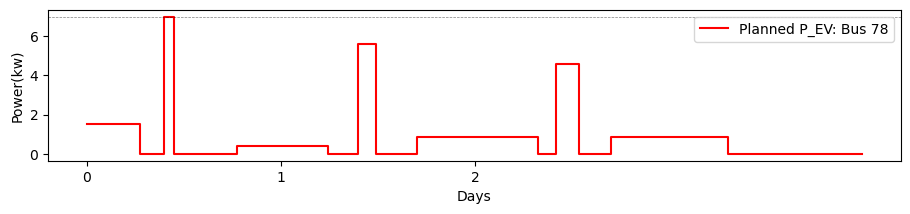

In [15]:
cur_bus = list(ev_data.keys())
#Plotting Planned EV data for a bus
plt.figure(figsize=(11,2), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(p_ev_plan[cur_bus[0]]*s_base/1000, 'r',ds='steps' )
# plt.plot(p_ev_plan[cur_bus[1]]*s_base/1000, 'b',ds='steps')
plt.axhline(7, color='k', lw=0.5,ls='--', alpha=0.5)

# plt.plot(p_ev_plan[cur_bus]*s_base/1000, 'r', q_ev_plan[cur_bus], 'b-')
# plt.legend([f'Planned P_EV: Bus {cur_bus[0]}', f'Planned PEV: Bus {cur_bus[1]}'], loc='best')
plt.legend([f'Planned P_EV: Bus {cur_bus[0]}'], loc='best')
plt.xticks(range(0,4000//probVar.Δt,1444//probVar.Δt),labels=range(0,3));
plt.xlabel('Days');
plt.ylabel('Power(kw)');
# plt.savefig('evv.pdf')

### Compute P_plan

In [16]:
# Planned BRP power for each settlement period
p_plan = brp.compute_Pplan(p_pv_plan, p_load_plan, p_ev_plan )

### Define $Soc_{sas,a}(I)$ and $Worst_{sas,a}(I)$

For an EV on bus a in the network, let us introduce the soc satisfaction $Soc_{sas,a}(I)$ and the worst sactisfaction $Worst_{sas,a}(I)$ on the pluged-in instant $I$ computed as follows
> ### $$Soc_{sas,a}(I) =  \big( Soc_{dep,a}^{dumb}(I) - Soc_{dep,a}^{mpc}(I) \big)^{+}$$
> ### $$Worst_{sas,a(I)} =  \big( Soc_{dep,a}^{dumb}(I) - Soc_{arr,a}^{dumb}(I) \big)$$

The $Worst_{sas,a}(I)$ is the percentange of Soc not reached if the MPC strategy did not charge at all the EV on bus a while it was connected on interval $I$. 

The $Soc_{sas,a}(I)$ is the difference of EV's Soc on bus a at departure time on interval $I$ between the dumb strategy and the MPC.

If for the Ev on bus a, the MPC strategy Soc at departure is lower than that of the dumb strategy, $Soc_{sas,a}(I) > 0 $  and the $Worst_{sas,a}(I)$ exists.

On the contrary, i.e., for Ev on bus a Soc at departure with MPC is greater or equal to that of the dumb strategy,  $Soc_{sas,a} = 0 $ and the $Worst_{sas,a} = 0$

</br >

For each Ev, we can therefore define the mean $\overline{Soc_{sas,a}}$ and the worst sactisfaction $\overline{Worst_{sas,a}}$ as

> ### $$\overline{Soc_{sas,a}} =  mean\big( Soc_{sas,a}(I) \big) = \dfrac{1}{I'} \sum_{I=1}^{I'} Soc_{sas,a}(I)$$
> ### $$\overline{Worst_{sas,a}} =  mean\big( Worst_{sas,a}(I) \big) = \dfrac{1}{I'} \sum_{I=1}^{I'} Worst_{sas,a}(I)$$



## Show simulation results

### Compute Variables to plot

In [17]:
ΔT = probVar.ΔT
Δt = probVar.Δt

####  Compute dumb strategy soc
soc_prob_dumb = brp.compute_DumbSoc(p_ev_plan, ev_data, t_sim)


# Create an array such that 
# pplan_delt = [p_plan[0],p_plan[0] ... p_plan[0], p_plan[1],p_plan[1] ... p_plan[1], ...,  p_plan[-1],p_plan[-1] ... p_plan[-1]]
# the number of time an element repeats is ΔT
pplan_delt = np.kron(p_plan, np.ones((ΔT,)) )

day_2_imba = day2_min//Δt     # Number of the first imbalance period of day 2
day_last_imba = fullDay_min*(nb_sim_days+1)//Δt

pload_pv = 0 
for elm in p_load:
    pload_pv = pload_pv  + p_pv[elm] - p_load[elm][:len(p_pv[elm])]

p_EV_char = 0 
for elm in p_ev_chrg_prob:
    p_EV_char = p_EV_char + p_ev_chrg_prob[elm][0,] 

p_EV_char_dumb = 0 
for elm in p_ev_chrg_prob:
    p_EV_char_dumb = p_EV_char_dumb + p_ev_plan[elm][:nb_sim_days*probVar.per_day]

### Show $\overline{Soc_{sas,a}}$ and $\overline{Worst_{sas,a}}$ for all bus in the Network

Note that for the Ev on bus a, 

- $\overline{Soc_{sas,a}} = \overline{Worst_{sas,a}} = 0 \implies$  MPC charges at least as much as the Dumb strategy; 
- $\overline{Soc_{sas,a}} \approx \overline{Worst_{sas,a}} \neq 0 \implies$  MPC doest not charge at all; 
- $\overline{Soc_{sas,a}} \neq \overline{Worst_{sas,a}}$ the better the MPC charges ;  

Worst_sas: 0.2568086195782703
Soc_sas: 0.07050181958744392


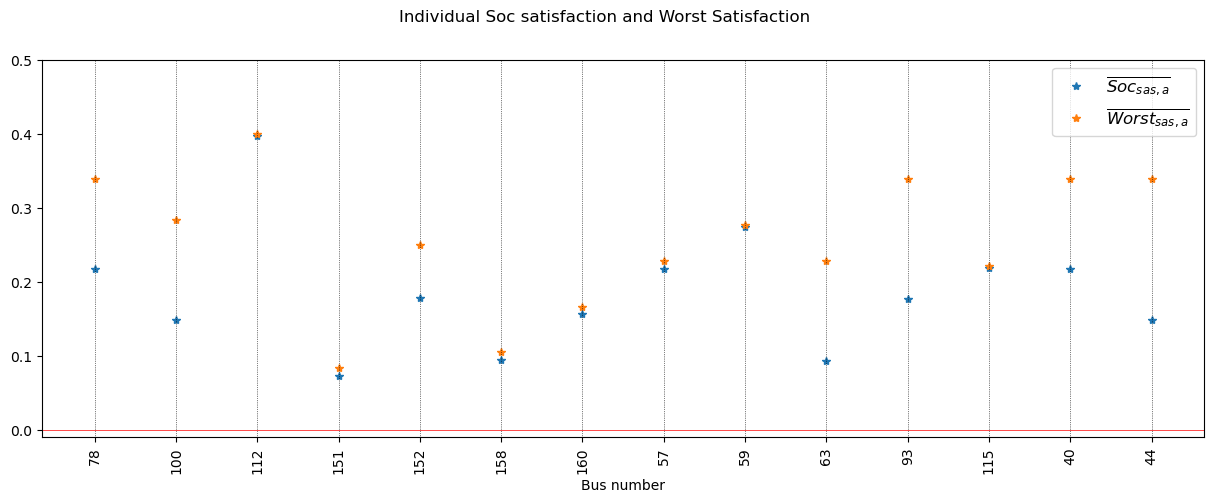

In [18]:
# soc_sat_res = mpc.soc_satisfaction(ev_data, soc_prob, soc_prob_dumb)
soc_sat_res = result_dict2['soc_satisfaction']
plt.figure(figsize=(15,5), dpi=100)
plt.plot(soc_sat_res[0], '*',);
plt.plot(soc_sat_res[1], '*',);
for ii in range (len(soc_sat_res[0])):
    plt.axvline(ii, ls= ':', lw=0.5,color='k' )
plt.legend(['$\overline{Soc_{sas,a}}$', '$\overline{Worst_{sas,a}}$'], fontsize=12)
plt.axhline(0, lw=0.5, color='red')
plt.ylim((-0.01,0.5))
plt.xlabel("Bus number")
plt.xticks(range(0,len(ev_data.keys())), labels=ev_data.keys(), rotation=90);
plt.suptitle('Individual Soc satisfaction and Worst Satisfaction')

print(f'Worst_sas: {np.mean(soc_sat_res[1])}') # Mean Worst_sas over all the EV in the Network
print(f'Soc_sas: {np.mean(soc_sat_res[1])-np.mean(soc_sat_res[0])}') # Mean Soc_sas over all the EV in the Network


### Plot Energy mismatch

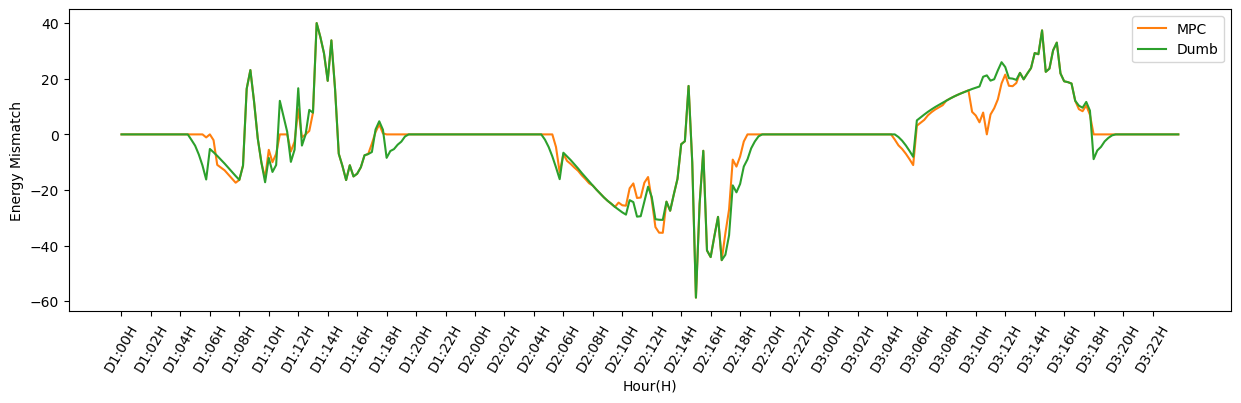

In [19]:
def colorUnpluggedPeriod():
    for cur_bus ,indx in zip(ev_data,range(len(ev_data))):
        for cur_int in range(1, nb_arr_dep):
            dep = ev_data[cur_bus]['t_dep'+str(cur_int)]/ΔT
            arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)]/ΔT  
            plt.axvspan(dep,arr,color=col[indx],alpha=0.08)

r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,2))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,2).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]

kwargs = (dict(label='MPC',color='tab:orange'),dict(label='Dumb',color='tab:green'))

dumb_mis = pplan_delt[:nb_sim_days*probVar.per_day] - (pload_pv[day_2_imba:day_last_imba] - p_EV_char_dumb)*s_base/1000
dumb_mis = Δt*np.sum(np.reshape(dumb_mis,(-1,ΔT)),axis=1)/60
mpc_mis = np.sum(np.reshape(zero_to_k_Emis,(-1,ΔT)),axis=1)

plt.figure(figsize=(15,4), dpi=100)
col = ['r', 'b']
plt.plot(mpc_mis,**kwargs[0] )
plt.plot(dumb_mis, **kwargs[1])
# plt.plot(abs(np.sum(np.reshape(zero_to_k_Emis,(-1,ΔT)),axis=1)))
# plt.xticks(range(0,nb_sim_days*96,4), labels=range(0,nb_sim_days*24));
plt.xticks(range(0,nb_sim_days*96,8), labels=labells, rotation=60);
# colorUnpluggedPeriod()
# # # plt.xlim([0,95])

            
plt.ylabel('Energy Mismatch')
plt.xlabel('Hour(H)');
plt.legend();
# plt.xlim((150,200))
# plt.ylim((-2,2))

## Optimization objectives

(0.0, 10.0)

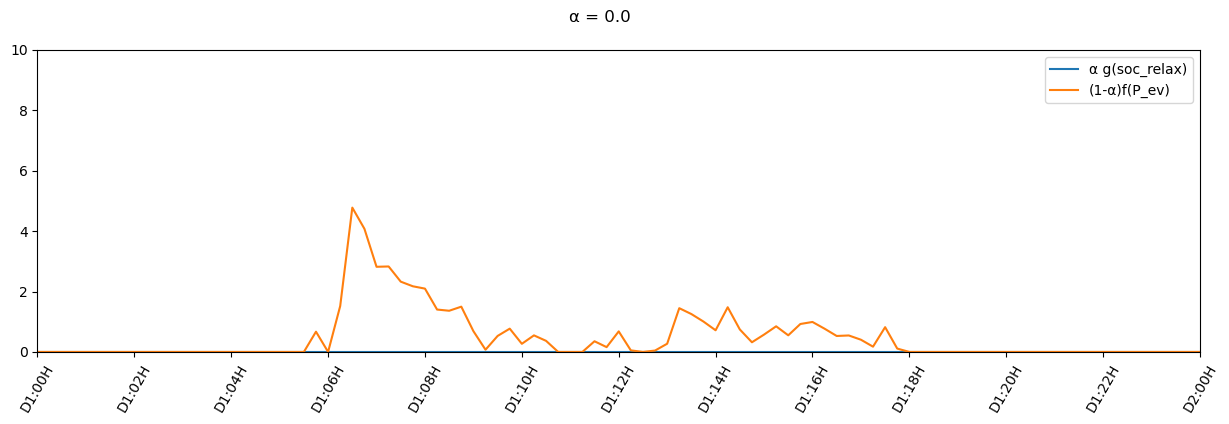

In [20]:
plt.figure(figsize=(15,4), dpi=100)
# colorUnpluggedPeriod()

plt.plot(result_dict2['soc_relax'])
plt.plot(result_dict2['Imb_cost'])
plt.xticks(range(0,nb_sim_days*96,8), labels=labells, rotation=60);
plt.legend(['α g(soc_relax)', '(1-α)f(P_ev)'])
plt.suptitle('α = '+str(α))
plt.xlim((0,96));
plt.ylim(0,10)

## Energy mismatch

In [21]:
print(f'Dumb: {np.round(sum(abs(dumb_mis)),decimals=2)} kWh')
print(f'MPC : {np.round(sum(abs(mpc_mis)) ,decimals=2)} kWh')

Dumb: 2762.32 kWh
MPC : 2384.24 kWh


### Chose randomly 2 Evs in the network and plot their Soc and P_ev

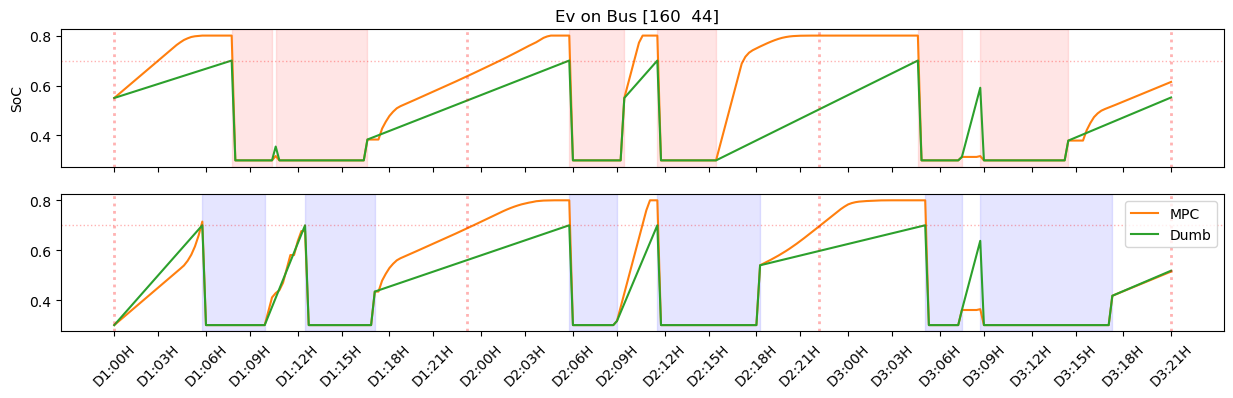

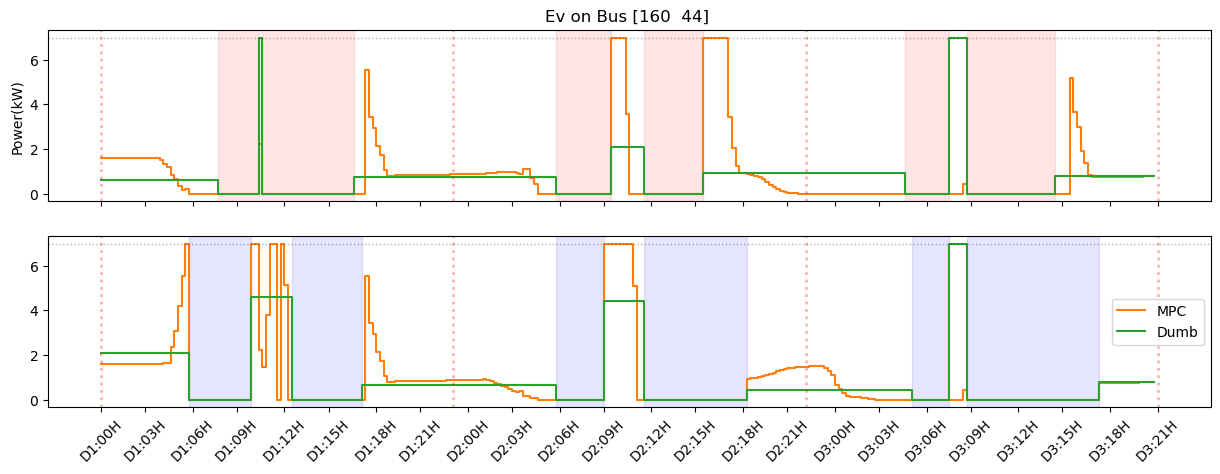

In [22]:
r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,nb_sim_days))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,nb_sim_days).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]
per_day = probVar.fullDay_min//Δt

in_ticks = np.linspace(0,nb_sim_days*per_day,24, dtype=int)

leng = 15 

np_plots = 2 # Number of bus to plot

# Choose randomly np_plots element to plot soc dynamic
evv_data = {} 
bus_to_choose = np.random.choice(np.array(list(ev_data.keys())),np_plots)
[evv_data.update({elm:ev_data[elm] }) for elm in bus_to_choose ];

fig, axx = plt.subplots(2,1,figsize=(leng,4), dpi=100, sharex=True)

for axis,cur_bus ,indx in zip(axx.flatten(), evv_data, range(len(evv_data))):
    axis.plot(soc_prob[cur_bus][0,],**kwargs[0]);
    axis.plot(soc_prob_dumb[cur_bus], **kwargs[1]);
    axis.axhline(0.7, color='r', ls=':', lw=1, alpha=0.3)# Set a line at 
    
    for cur_int in range(1,nb_arr_dep):
        dep = ev_data[cur_bus]['t_dep'+str(cur_int)]
        arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)] 
        axis.axvspan(dep,arr,color=col[indx],alpha=0.1)
    

    # COlor starting of each day    
    for cur_day in range(nb_sim_days+1):
        axis.axvline(per_day*cur_day, color='r', ls=':', lw=2, alpha=0.3)# Set a line at 
        
plt.xticks(in_ticks, labels=labells,rotation=45)
var = np.array(list(evv_data.keys()))
axx[0].set(ylabel='SoC',title=f'Ev on Bus {var}  ');
# axx[1].set(ylabel='SoC',title= f'Ev on Bus {var[1]}');
plt.legend(['MPC', 'Dumb']);


fig, axx = plt.subplots(2,1,figsize=(leng,5), dpi=100, sharex=True)
for axis, cur_bus,indx in zip(axx.flatten(), evv_data, range(len(ev_data))):
    axis.plot(p_ev_chrg_prob[cur_bus][0,:t_sim]*s_base/1000,ds='steps-post',**kwargs[0]);
    axis.plot(p_ev_plan[cur_bus][:t_sim]*s_base/1000,ds='steps-post',**kwargs[1]);

    for cur_int in range(1,nb_arr_dep):
        dep = ev_data[cur_bus]['t_dep'+str(cur_int)]
        arr = ev_data[cur_bus]['t_arr'+str(cur_int+1)] 
        axis.axvspan(dep,arr,color=col[indx],alpha=0.1)
    # COlor starting of each day    
    for cur_day in range(nb_sim_days+1):
        axis.axvline(per_day*cur_day, color='r', ls=':', lw=2, alpha=0.3)# Set a line at 
        
    axis.axhline(p_max, color='k', ls=':', lw=1, alpha=0.3)# Set a line at 
        
plt.xticks(in_ticks,labels=labells,rotation=45)
axx[0].set(ylabel='Power(kW)',title=f'Ev on Bus {var} ');
# axx[1].set(ylabel='Power(kW)',title=' Ev on Bus 203 ');
plt.legend(['MPC', 'Dumb']);


### Plot mean Soc ($\overline{Soc}$) and mean P_ev ($\overline{P_{ev}}$) of all Evs in the network

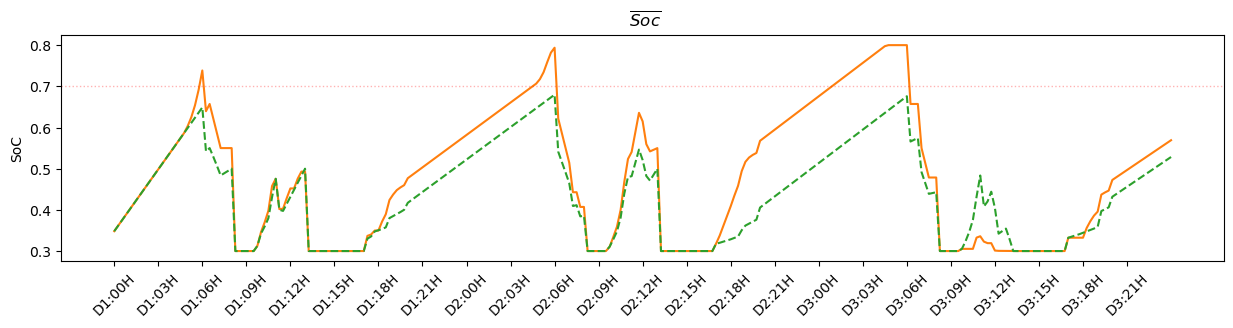

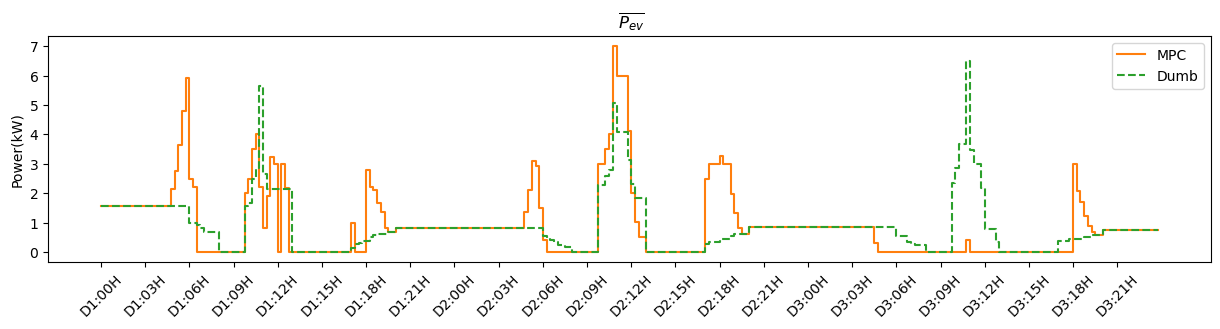

In [23]:
soc_sum_mpc = np.zeros(t_sim+1)
soc_sum_dumb = np.zeros(t_sim+1)
p_ev_sum_mpc = np.zeros(t_sim)
p_ev_sum_dumb = np.zeros(t_sim)

r1 = np.kron(np.ones((nb_sim_days), dtype=int), np.arange(0,24,nb_sim_days))
r2 = np.kron( np.arange(1,nb_sim_days+1),np.ones((np.arange(0,24,nb_sim_days).shape[0]),dtype=int))
labells = [f'D{Day}:{hour:>02}H' for Day,hour in zip(r2,r1)]
per_day = probVar.fullDay_min//Δt
leng = 15 


fig, axx = plt.subplots(1,1,figsize=(leng,3), dpi=100, sharex=True)
for cur_bus in ev_data:
    soc_sum_mpc = soc_sum_mpc + soc_prob[cur_bus][0,]
    soc_sum_dumb = soc_sum_dumb + soc_prob_dumb[cur_bus]
    
# colorUnpluggedPeriod()

axx.plot(soc_sum_mpc/len(ev_data),**kwargs[0]);
axx.plot(soc_sum_dumb/len(ev_data),ls='--', **kwargs[1]);
axx.axhline(0.7, color='r', ls=':', lw=1, alpha=0.3) # Set a line at 
plt.xticks(range(0,nb_sim_days*per_day,nb_sim_days*4),labels=labells,rotation=45)
axx.set(ylabel='SoC',title=' $\overline{Soc}$');


fig, axx = plt.subplots(1,1,figsize=(leng,3), dpi=100, sharex=True)
for cur_bus in ev_data:
    p_ev_sum_mpc += p_ev_chrg_prob[cur_bus][0,:t_sim]
    p_ev_sum_dumb += p_ev_plan[cur_bus][:t_sim]

# colorUnpluggedPeriod()

axx.plot(p_ev_sum_mpc/len(ev_data)*s_base/1000,ds='steps-post',**kwargs[0]);
axx.plot(p_ev_sum_dumb/len(ev_data)*s_base/1000,ls='--', ds='steps-post',**kwargs[1]);
plt.xticks(range(0,nb_sim_days*per_day,nb_sim_days*4),labels=labells,rotation=45)
axx.set(ylabel='Power(kW)',title=' $\overline{P_{ev}}$ ');
plt.legend(['MPC', 'Dumb']);


### Plot Pplan, P_BRP dumb  P_BRP MPC

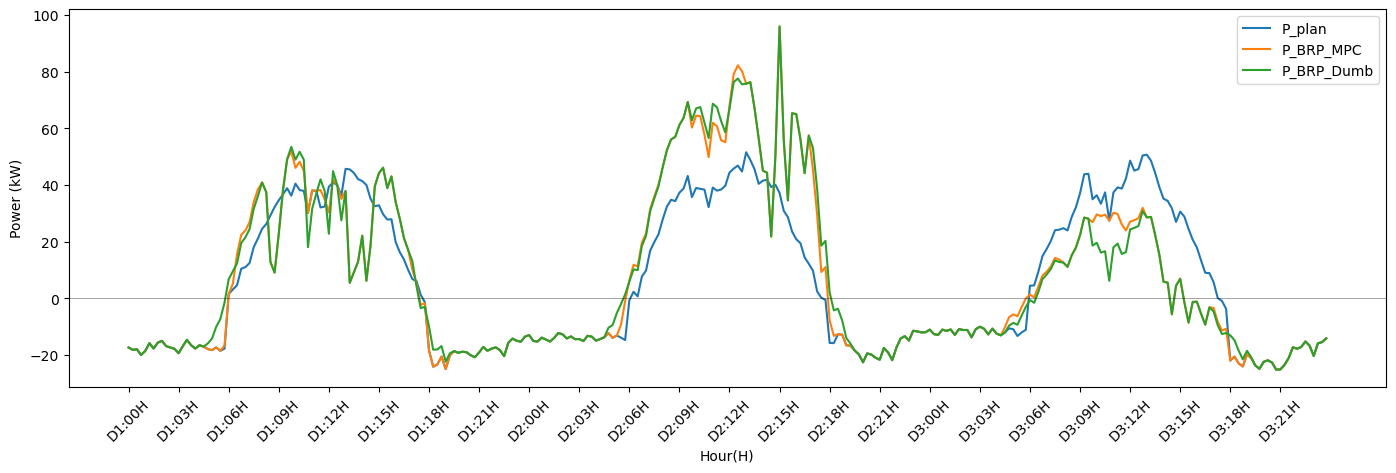

In [24]:
plt.figure(figsize=(17,5), dpi=100)
plt.plot(pplan_delt[:nb_sim_days*day_2_imba]/(60/15), label='P_plan',)
plt.plot((pload_pv[day_2_imba:day_last_imba] - p_EV_char)*s_base/1000/(60/15), label='P_BRP_MPC')
plt.plot((pload_pv[day_2_imba:day_last_imba] - p_EV_char_dumb)*s_base/1000/(60/15), label='P_BRP_Dumb')

plt.axhline(y=0, color='k', alpha =0.5,lw=0.5)
plt.xticks(range(0,day_2_imba*nb_sim_days,nb_sim_days*60//Δt), labels=labells, rotation=45);

plt.legend();
plt.ylabel('Power (kW)')
plt.xlabel('Hour(H)');

### Zoom on a part of the previous figure

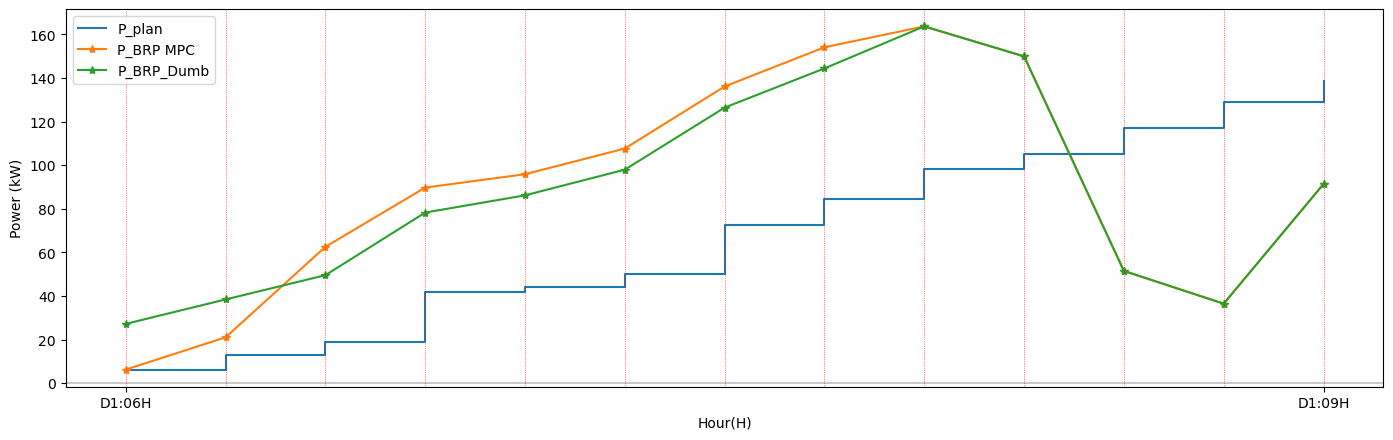

In [25]:
plt.figure(figsize=(17,5), dpi=100)

h1 = 6 # Starting hour to plot 
h2 = 9# Ending hour to plot 

h_start =  h1*(60//Δt)    # First 
h_end = h2*(60//Δt) + 1

plt.plot(pplan_delt[h_start:h_end], label='P_plan',ds='steps-post')
# plt.plot(pload_pv[h_start+day_2_imba:day_2_imba+h_end]*s_base/1000, label='P_BRP (No Ev)', marker='*')
plt.plot((pload_pv[h_start+day_2_imba:day_2_imba+h_end] - p_EV_char[h_start:h_end])*s_base/1000, label='P_BRP MPC', marker='*',)
plt.plot((pload_pv[h_start+day_2_imba:day_2_imba+h_end] - p_EV_char_dumb[h_start:h_end])*s_base/1000, label='P_BRP_Dumb', marker='*',)


plt.legend()
# # plt.xticks(range(0,h_end,60//Δt),labels=range(len(range(0,h_end,60//Δt))))
plt.xticks(range(0,h_end-h_start,60*nb_sim_days//Δt),labels=labells[h1//nb_sim_days:(h2//nb_sim_days)+1])

for ii in range(0,h_end-h_start,ΔT):
    plt.axvline(x=ii, color='red', lw=0.5, ls=':')
    
plt.axhline(0,color='k',lw=0.3)
plt.ylabel('Power (kW)')
plt.xlabel('Hour(H)');
# plt.ylim((-30,-18))

---

<a id="ENMIS"></a>

### Energy mismatch for `α` for all value of MPC's Horizon

In [26]:
nb_sim_days = 3# Total number of simulation days
t_sim = nb_sim_days*probVar.fullDay_min//probVar.Δt      #Total duration of the study(in minutes)
ΔT = probVar.ΔT
Δt = probVar.Δt

α = 0.999
# alpha = [0., 0.5, 0.999]

print(f'** {len(ev_data)} Ev(s) in total in the network **\n')

print(f'_____   Total Energy Mismatch   _____ \n')

print('----   Dumb  ----    ----  MPC  ----- ')
for hor_string in probVar.hor_dict : 
    file_toRead_loc = '../DataFiles/MPC_V1G/' # Define File location
    file_name = 'MPC_Mosek_RelaxVar='+str(α)+'_'+ str(len(evs_data_df))+'cars3Days_Pv_rgSwitch_hor='+hor_string+'.pkl'  
    file_to_read = open(file_toRead_loc+file_name, 'rb')

    result_dict2 = pickle.load(file_to_read);

    zero_to_k_Emis = result_dict2['E_mis_min']
    p_ev_chrg_prob = result_dict2['p_ev_chrg_prob']
    soc_prob = result_dict2['soc_prob']
    theta_prob = result_dict2['theta_prob']
    ev_data = result_dict2['Ev_data']
    p_ev_plan = result_dict2['pev_plan']


    # Planned BRP power for each settlement period
    p_plan = brp.compute_Pplan(p_pv_plan, p_load_plan, p_ev_plan )

    ####  Compute dumb strategy soc
    soc_prob_dumb = brp.compute_DumbSoc(p_ev_plan, ev_data, t_sim)

    # Create an array such that 
    # pplan_delt = [p_plan[0],p_plan[0] ... p_plan[0], p_plan[1],p_plan[1] ... p_plan[1], ...,  p_plan[-1],p_plan[-1] ... p_plan[-1]]
    # the number of time an element repeats is ΔT
    pplan_delt = np.kron(p_plan, np.ones((ΔT,)) )

    day_2_imba = day2_min//Δt     # Number of the first imbalance period of day 2
    day_last_imba = fullDay_min*(nb_sim_days+1)//Δt

    pload_pv = 0 
    for elm in p_load:
        pload_pv = pload_pv  + p_pv[elm] - p_load[elm][:len(p_pv[elm])]

    p_EV_char = 0 
    for elm in p_ev_chrg_prob:
        p_EV_char = p_EV_char + p_ev_chrg_prob[elm][0,] 

    p_EV_char_dumb = 0 
    for elm in p_ev_chrg_prob:
        p_EV_char_dumb = p_EV_char_dumb + p_ev_plan[elm][:nb_sim_days*probVar.per_day]


    dumb_mis = pplan_delt[:nb_sim_days*probVar.per_day] - (pload_pv[day_2_imba:day_last_imba] - p_EV_char_dumb)*s_base/1000
    dumb_mis = Δt*np.sum(np.reshape(dumb_mis,(-1,ΔT)),axis=1)/60
    mpc_mis = np.sum(np.reshape(zero_to_k_Emis,(-1,ΔT)),axis=1)

    print(f" {hor_string}_______________________________ ")
    
    print(f'      {np.round(sum(abs(dumb_mis)),decimals=2)} kWh\t{np.round(sum(abs(mpc_mis)) ,decimals=2)} kWh')


** 14 Ev(s) in total in the network **

_____   Total Energy Mismatch   _____ 

----   Dumb  ----    ----  MPC  ----- 
 15mn_______________________________ 
      2762.32 kWh	2416.0 kWh
 30mn_______________________________ 
      2762.32 kWh	2437.91 kWh
 01H_______________________________ 
      2762.32 kWh	2474.94 kWh
 02H_______________________________ 
      2762.32 kWh	2502.13 kWh
 04H_______________________________ 
      2762.32 kWh	2501.22 kWh
 06H_______________________________ 
      2762.32 kWh	2501.26 kWh
 08H_______________________________ 
      2762.32 kWh	2500.9 kWh
 12H_______________________________ 
      2762.32 kWh	2501.18 kWh
 24H_______________________________ 
      2762.32 kWh	2500.93 kWh
